# ExoNAMD API v1.0


## Summary

The observer wants to compute the relative and/or absolute NAMD of:

- a given multiplanetary system;
- a subset of multiplanetary systems;
- all the known ones.

This tool handles all of the above cases.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
# import modin.pandas as pd
import swifter
import warnings

from exonamd.catalog import download_nasa_confirmed_planets
from exonamd.utils import ROOT
from exonamd.utils import fetch_aliases
from exonamd.utils import update_host
from exonamd.utils import update_planet
from exonamd.solve import solve_values
from exonamd.interp import interp_eccentricity
from exonamd.interp import interp_mass
from exonamd.interp import interp_inclination
from exonamd.interp import interp_sma
from exonamd.solve import solve_relincl
from exonamd.interp import interp_trueobliq
from exonamd.solve import solve_amd
from exonamd.utils import groupby_apply_merge
from exonamd.solve import solve_namd
from exonamd.solve import solve_amd_mc
from exonamd.solve import solve_namd_mc
from exonamd.plot import simple_plot


warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
# warnings.filterwarnings("ignore", category=UserWarning, module="modin")
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

### Task 1: getting the data

This task retrieves the parameters of confirmed systems from the NASA Exoplanet Archive database.


In [ ]:
df, df_old = download_nasa_confirmed_planets(
    sy_pnum=1,
    from_scratch=False,
)

### Task 2: dealing with the aliases


Fetch aliases


In [ ]:
aliases = fetch_aliases(df["hostname"].unique())

Curate aliases


In [ ]:
df["hostname"] = df.swifter.apply(update_host, args=(aliases,), axis=1)
df["pl_name"] = df.swifter.apply(update_planet, args=(aliases,), axis=1)

Check consistency of planet names


In [ ]:
def check_name(names):
    if len(set(name[:3] for name in names)) > 1:
        return False
    return True


name_ok = df.groupby("hostname")["pl_name"].apply(check_name)

for hostname in name_ok[~name_ok].index:
    print(f"Inconsistent planet names for {hostname}")

### Task 3: computing missing values (if any) from simple equations


In [ ]:
df[
    [
        "pl_orbsmax",
        "pl_ratdor",
        "st_rad",
        "pl_rade",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ]
] = df.swifter.apply(solve_values, axis=1)

### Task 4: storing the curated database


In [ ]:
if df_old is not None:
    df_new = df.copy()
    df = pd.concat([df_new, df_old], ignore_index=True)
    df = df.drop_duplicates(keep="last")
    df.reset_index(drop=True)

df.to_csv(os.path.join(ROOT, "data", "exo.csv"), index=False)

In [ ]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo.csv"))

Drop columns that are no longer needed


In [ ]:
df.drop(
    columns=[
        "pl_ratdor",
        "st_rad",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ],
    inplace=True,
)

### Task 5: input missing values (if any) by interpolation


Use nanmedian to thin down the data


In [ ]:
cols = [
    c
    for c in df.columns
    if c not in ["hostname", "pl_name", "default_flag", "rowupdate"]
]

medians = df.groupby("pl_name")[cols].transform(np.nanmedian)
df.loc[df["default_flag"] == 1, cols] = medians.loc[df["default_flag"] == 1]
df = df[df["default_flag"] == 1]
df.drop(columns="default_flag", inplace=True)

TODO: Check presence of duplicates!!!


In [ ]:
len(df.hostname.unique()), len(df.pl_name.unique()), len(df)
df[df.duplicated(subset=["hostname", "pl_name"], keep=False)].sort_values(
    by=["hostname", "pl_name"]
)

Instantiate flags


In [ ]:
df["flag"] = "0"

Solve missing eccentricity values


In [ ]:
df[
    [
        "pl_orbeccen",
        "pl_orbeccenerr1",
        "pl_orbeccenerr2",
        "flag",
    ]
] = df.swifter.apply(interp_eccentricity, axis=1)

Solve missing planetary mass values


In [ ]:
df[
    [
        "pl_bmasse",
        "pl_bmasseerr1",
        "pl_bmasseerr2",
        "flag",
    ]
] = df.swifter.apply(interp_mass, axis=1)

Drop columns that are no longer needed


In [ ]:
df = df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"])

Remove systems where at least one planet has no mass or semi-major axis (if any)


In [ ]:
mask = (
    df.groupby("hostname")[["pl_bmasse", "pl_orbsmax"]]
    .transform(lambda x: x.isnull().any())
    .any(axis=1)
)
df = df[~mask]

Solve missing values in inclinations


In [ ]:
df[
    [
        "pl_orbincl",
        "pl_orbinclerr1",
        "pl_orbinclerr2",
        "flag",
    ]
] = df.swifter.apply(interp_inclination, args=(df,), axis=1)

Interpolate missing values in semi-major axis uncertainties


In [ ]:
df[
    [
        "pl_orbsmaxerr1",
        "pl_orbsmaxerr2",
        "flag",
    ]
] = df.swifter.apply(interp_sma, axis=1)

### Task 6: compute the parameters for the NAMD calculation


Compute the relative inclination


In [ ]:
df[
    [
        "pl_relincl",
        "pl_relinclerr1",
        "pl_relinclerr2",
    ]
] = df.swifter.apply(solve_relincl, args=(df,), axis=1)

Interpolate missing values in true obliquity


In [ ]:
df[
    [
        "pl_trueobliq",
        "pl_trueobliqerr1",
        "pl_trueobliqerr2",
        "flag",
    ]
] = df.swifter.apply(interp_trueobliq, args=(df,), axis=1)

### Task 7: storing the curated+interpolated database


In [ ]:
df.to_csv(os.path.join(ROOT, "data", "exo_interp.csv"), index=False)

In [3]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_interp.csv"))

### Task 8: computing the AMD


Solve the relative and absolute amd


In [4]:
df["amd_rel"] = df.swifter.apply(solve_amd, args=("rel",), axis=1)
df["amd_abs"] = df.swifter.apply(solve_amd, args=("abs",), axis=1)

Pandas Apply:   0%|          | 0/2208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2208 [00:00<?, ?it/s]

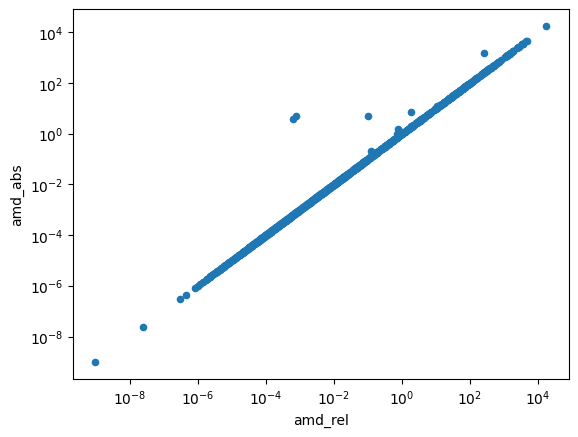

In [5]:
_ = df[["amd_rel", "amd_abs"]].plot(
    kind="scatter", x="amd_rel", y="amd_abs", loglog=True
)

### Task 9: computing the NAMD


Solve the relative and absolute namd


In [6]:
df = groupby_apply_merge(df, "hostname", solve_namd, kind="rel")
df = groupby_apply_merge(df, "hostname", solve_namd, kind="abs")

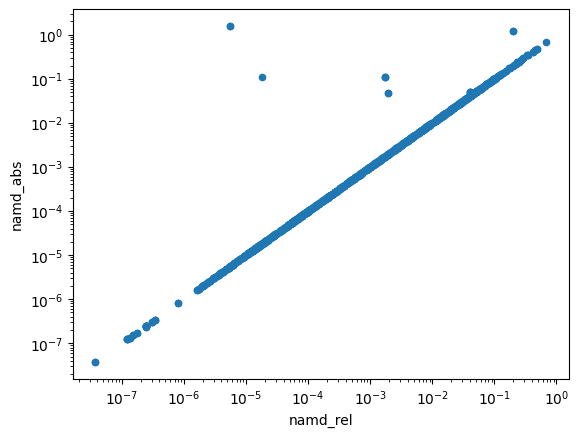

In [7]:
_ = df[["namd_rel", "namd_abs"]].plot(
    kind="scatter", x="namd_rel", y="namd_abs", loglog=True
)

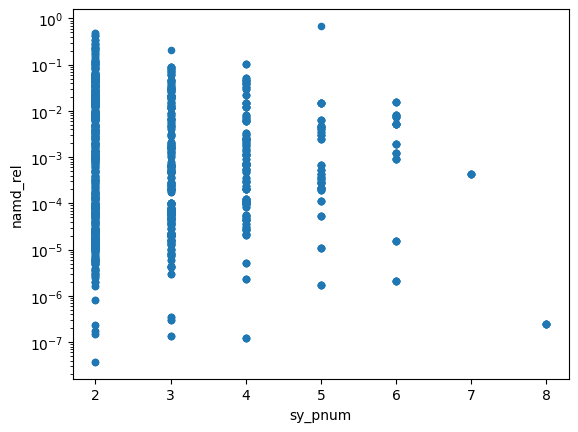

In [8]:
_ = df[["sy_pnum", "namd_rel"]].plot(
    kind="scatter", x="sy_pnum", y="namd_rel", logy=True
)

In [9]:
# if interested only in core planets
core_flags = ["0", "05+", "05-", "05+-"]
df_core = df[df["flag"].isin(core_flags)]

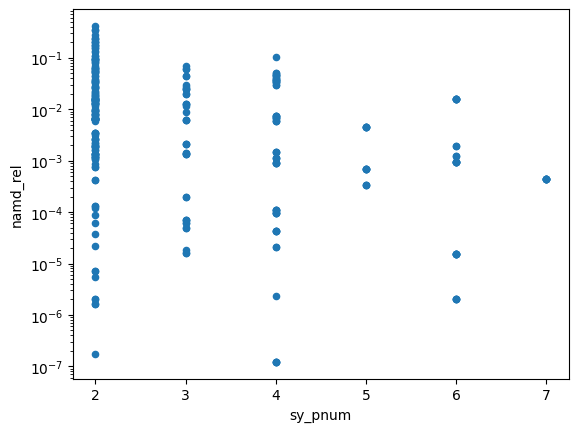

In [10]:
_ = df_core[["sy_pnum", "namd_rel"]].plot(
    kind="scatter", x="sy_pnum", y="namd_rel", logy=True
)

### Task 10: computing the AMD and associated confidence intervals


In [11]:
Npt = 100000
threshold = 5000

In [12]:
df_core[["amd_rel_mc", "amd_rel_q16", "amd_rel_q50", "amd_rel_q84"]] = (
    df_core.swifter.apply(solve_amd_mc, args=("rel", Npt, threshold), axis=1)
)
df_core[["amd_abs_mc", "amd_abs_q16", "amd_abs_q50", "amd_abs_q84"]] = (
    df_core.swifter.apply(solve_amd_mc, args=("abs", Npt, threshold), axis=1)
)

Pandas Apply:   0%|          | 0/298 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/298 [00:00<?, ?it/s]

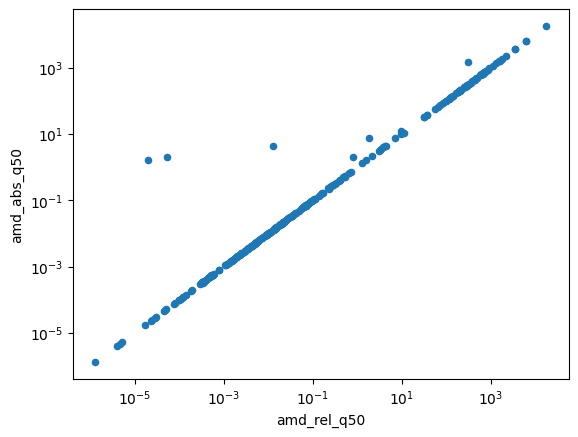

In [13]:
_ = df_core[["amd_rel_q50", "amd_abs_q50"]].plot(
    kind="scatter", x="amd_rel_q50", y="amd_abs_q50", loglog=True
)

### Task 10: computing the NAMD and associated confidence intervals


In [14]:
df_core = groupby_apply_merge(
    df_core,
    "hostname",
    solve_namd_mc,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
)

df_core = groupby_apply_merge(
    df_core,
    "hostname",
    solve_namd_mc,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
)

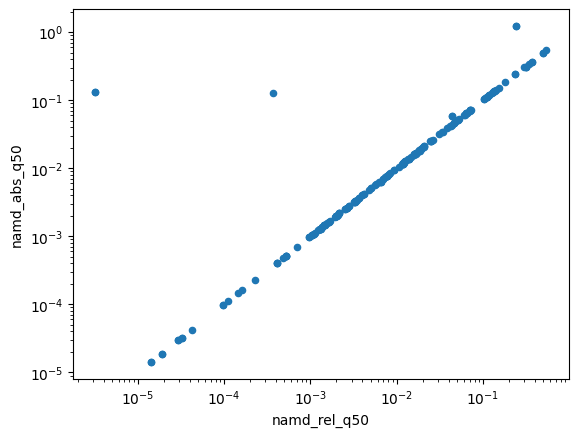

In [15]:
_ = df_core[["namd_rel_q50", "namd_abs_q50"]].plot(
    kind="scatter", x="namd_rel_q50", y="namd_abs_q50", loglog=True
)

### Some plots

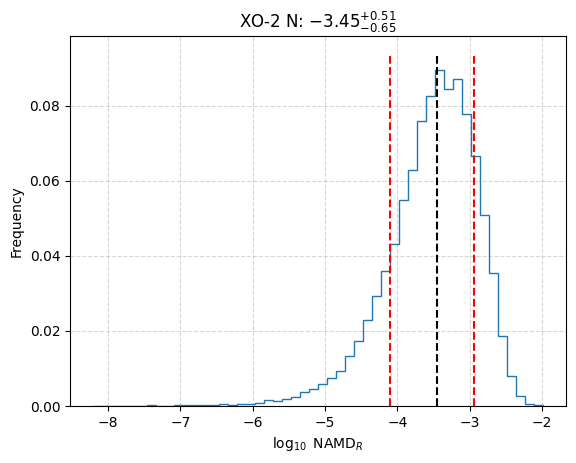

In [26]:
hostname = "XO-2 N"

host = df[df["hostname"] == hostname]

retval = solve_namd_mc(host, kind="rel", Npt=Npt, threshold=threshold, full=True)

simple_plot(
    data=retval,
    kind="rel",
    title=hostname,
    which="namd",
    scale="log",
)

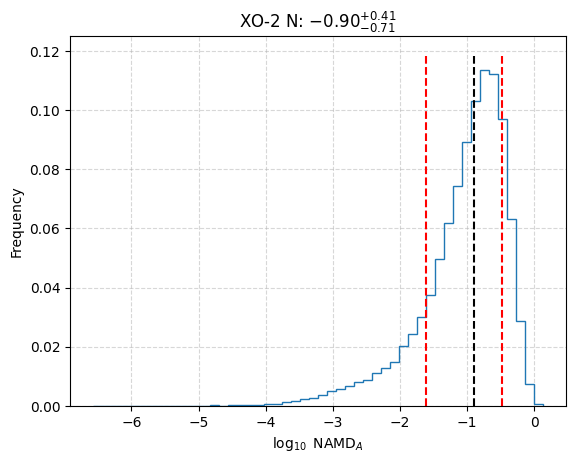

In [27]:
retval = solve_namd_mc(host, kind="abs", Npt=Npt, threshold=threshold, full=True)

simple_plot(
    data=retval,
    kind="abs",
    title=hostname,
    which="namd",
    scale="log",
)